In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import njit
from tqdm.notebook import tqdm
import talib
import pickle
import pystan

import os, sys

sys.path.append(os.path.abspath(os.path.join('../')))
from generative_models import *

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [3]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
%load_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)

## Stan

# Amortizer

## Network architecture

In [5]:
class HeteroscedasticNetwork(tf.keras.Model):
    
    def __init__(self, n_params_d, n_params_s):
        super(HeteroscedasticNetwork, self).__init__()
        
        self.preprocessor = Sequential([
            GRU(64, return_sequences=True),
            LSTM(128, return_sequences=True),
            Dense(128, activation='selu', kernel_initializer='lecun_normal'),
        ])
        
        self.dynamic_predictor = Sequential([
            Dense(64, activation='selu', kernel_initializer='lecun_normal'),
            tf.keras.layers.Dense(tfpl.MultivariateNormalTriL.params_size(n_params_d)),
            tfpl.MultivariateNormalTriL(n_params_d)
        ])

        self.static_predictor = Sequential([
            LSTM(n_params_s),
            Dense(tfpl.MultivariateNormalTriL.params_size(n_params_s)),
            tfpl.MultivariateNormalTriL(n_params_s)
        ])
        
    def call(self, x):
        """
        Forward pass through the model.
        """
        
        # Obtain representation
        rep = self.preprocessor(x)
        
        # Predict dynamic
        preds_dyn = self.dynamic_predictor(rep)

        # predict static
        preds_stat = self.static_predictor(rep)

        return preds_dyn, preds_stat

## Loss

In [6]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

## Epoch helper

In [7]:
def epoch_trainer(network, optimizer, batch_size, n_obs, steps_per_epoch, p_bar):
    losses = []
    for step in range(1, steps_per_epoch+1):
        with tf.GradientTape() as tape:
            # Simulate from model
            prior_draws = dynamic_prior(batch_size)
            context = context_gen(batch_size, n_obs)
            sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)

            # predict
            net_in = tf.concat((sim_data[:, :, :1], to_categorical(sim_data[:, :, 1:])), axis=-1)
            pred_theta_d, pred_theta_s = network(net_in)

            # loss
            loss_d = nll(theta_d, pred_theta_d)
            loss_s = nll(theta_s, pred_theta_s)
            total_loss = loss_d + loss_s

        g = tape.gradient(total_loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(total_loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss D: {:.3f} Running Loss: {:.3f}"
                              .format(ep, step, loss_d.numpy(), np.mean(losses)))
        p_bar.update(1)


# Training

In [8]:
N_OBS = 3200
BATCH_SIZE = 16
STEPS_PER_EPOCH = 1000
epochs = [50, 25, 20, 15, 10]
learning_rates = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]

In [10]:
# initialize net
network = HeteroscedasticNetwork(6, 6)

In [ ]:
for i in range(len(epochs)):
    # set learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rates[i])
    
    # train epochs
    for ep in range(1, epochs[i]+1):
        with tqdm(total=STEPS_PER_EPOCH, desc='Training epoch {}'.format(ep)) as p_bar:
            epoch_trainer(network, optimizer, BATCH_SIZE, N_OBS, STEPS_PER_EPOCH, p_bar)
    
    #save weights
    network.save_weights('checkpoints/varying_hyperparams_3200')

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2022-02-18 16:33:29.289763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-02-18 16:33:30.225873: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-18 16:33:30.450654: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x563635e3f140


# Model fitting

In [117]:
# initialize net
network = HeteroscedasticNetwork(6, 6)
network.load_weights('checkpoints/varying_hyperparams_800')

In [118]:
# read data
data = pd.read_csv('../../data/data_lexical_decision.csv', sep=',', header=0)

In [119]:
# subset data
which = 1
person_data = data[data.id == which]
person_data = person_data[person_data.session==1]
person_data.shape

(800, 13)

In [120]:
# prepare data for fitting
# negative rts for error responses
person_data.rt[person_data.acc == 0] = -person_data.rt[person_data.acc == 0]
rt = np.array([person_data.rt])[:, :, np.newaxis]
stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
context = to_categorical(stim_type)
x_nn = tf.concat((rt, context), axis=-1)
x_nn.shape

TensorShape([1, 800, 5])

In [121]:
# amortized inference
post_d, post_s = network(x_nn)

# Evaluation

In [122]:
def plot_dynamic_posteriors(dynamic_posterior, par_labels, par_names, 
                            ground_truths=None, color_pred='#884da3'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
    
    assert len(dynamic_posterior.shape) == 3, "Dynamic posterior should be 3-dimensional!" 
    assert ground_truths is None or len(ground_truths.shape) == 2,'Ground truths should be 2-dimensional!'
    assert dynamic_posterior.shape[0] == 1, "Function assumes dynamics posterior for a single data set!" 
        
    means = dynamic_posterior.mean()[0]
    std = dynamic_posterior.stddev()[0]
    
    sigma_factors = [1]
    alphas = [0.6]
    
    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        
        ax.plot(time, means[:, i], color=color_pred, label='Posterior Mean')
        for sigma_factor, alpha in zip(sigma_factors, alphas):
            ci_upper = means[:, i] + sigma_factor * std[:, i]
            ci_lower = means[:, i] - sigma_factor * std[:, i]
            ax.fill_between(time, ci_upper, ci_lower, color=color_pred, alpha=alpha)
        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color='black', linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)
        ax.grid(alpha=0.15)
        ax.set_xlabel('Time (t)')
        ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=12)
        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=12)
        
        if i == 0:
            f.legend()
    
    f.tight_layout()

In [123]:
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_3$', r'$a$', r'$\tau$']

## Parameter dynamics: Empiric data

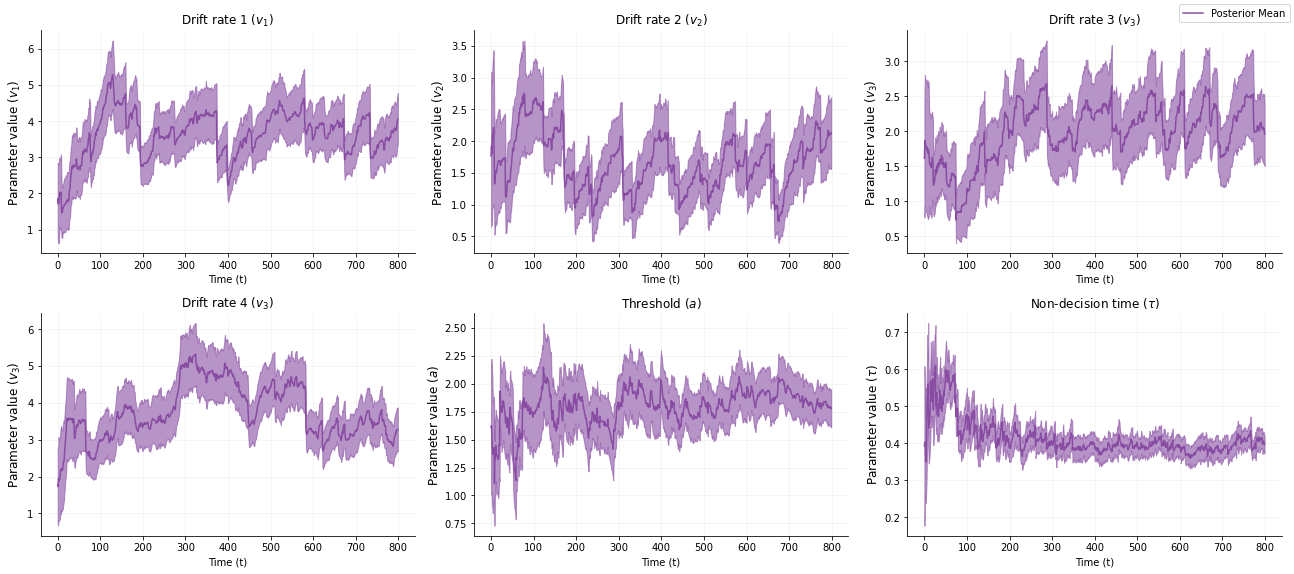

In [124]:
plot_dynamic_posteriors(post_d, par_labels,  par_names)

## Posterior retrodictive checks

In [125]:
def pr_check(emp_data, post_d, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    
    # sample from posterior
    theta_d = np.array([post_d.sample(n_sim)])[0, :, 0, :]

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(theta_d[sim, t, context[t]], theta_d[sim, t, 4], theta_d[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)
    
    # summarize predicted response times
    quantiles = np.quantile(sma_pred_rt, [0.05, 0.95], axis=0)
    median = np.median(sma_pred_rt, axis=0)
     
    # initialize figure
    f, ax = plt.subplots(1, 1, figsize=(24, 8))

    # plot empiric and predicted response times
    time = np.arange(n_obs) 
    ax.plot(time, sma_emp_rt, color='black', lw=2, label='SMA5(Empiric)')
    ax.plot(time, median, color='blue', lw=2, label='SMA5(Predicted-Median)', alpha=0.8)
    ax.fill_between(time, quantiles[0, :], quantiles[1, :], color='blue', alpha=0.3)
    for idx in np.argwhere(emp_data.session.diff().values == 1):
        ax.axvline(idx, color='black', linestyle='solid', lw=3, alpha=0.8)
    for idx in np.argwhere(emp_data.block.diff().values == 1):
        ax.axvline(idx, color='black', linestyle='dashed', alpha=0.5)
    sns.despine(ax=ax)
    ax.grid(alpha=0.3)
    ax.set_ylabel('RT(ms)')
    ax.set_xlabel('Time(t)')
    ax.legend()
    
    return pred_rt

CPU times: user 5.41 s, sys: 0 ns, total: 5.41 s
Wall time: 5.41 s


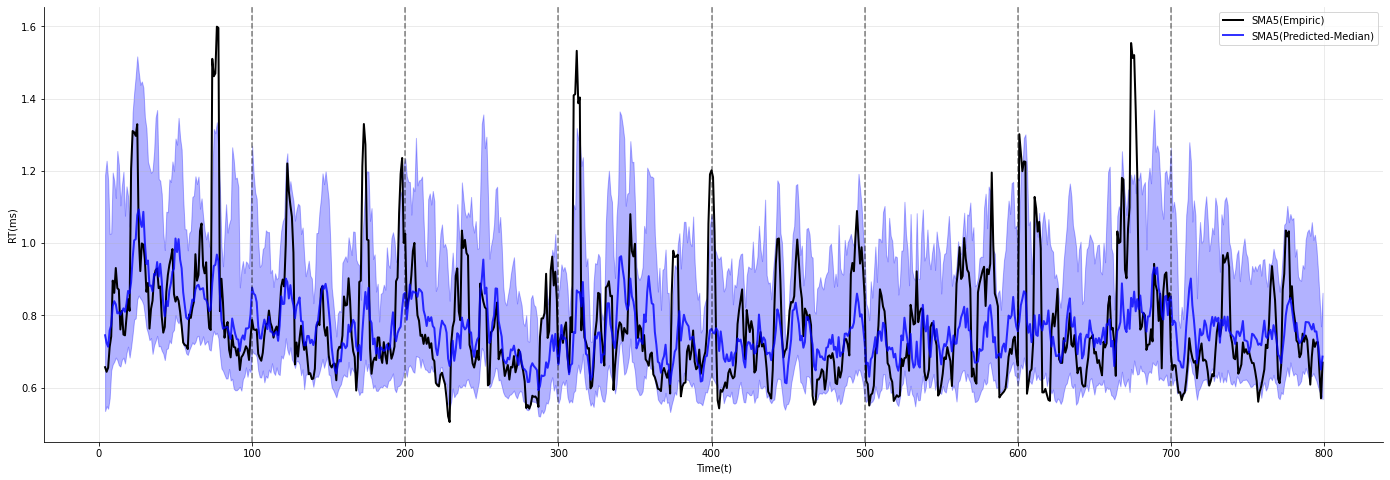

In [126]:
%%time
pred_rt = pr_check(person_data, post_d, 100)

## Empiric vs. predicted rt distribution

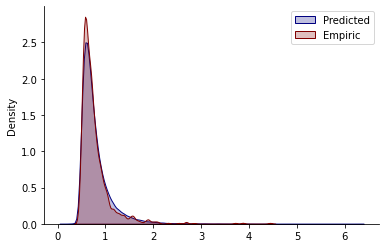

In [127]:
sns.kdeplot(pred_rt.flatten(), fill="navy", color="navy", label="Predicted")
sns.kdeplot(np.random.choice(np.abs(person_data.rt.values), size=pred_rt.flatten().size, replace=True), fill="maroon", color="maroon", label="Empiric")
sns.despine()
plt.legend()

## Parameter dynamics: Simulated data

In [128]:
# dynamic simulation
n_obs = 800
n_test = 6
prior_draws = dynamic_prior(n_test)
context = context_gen(n_test, n_obs)
sim_data, theta_d, theta_s = dynamic_batch_simulator(prior_draws, context)
context = to_categorical(sim_data[:, :, 1])
rt = sim_data[:, :, 0, np.newaxis]
x_nn = tf.concat((rt, context), axis=-1)
x_nn.shape

TensorShape([6, 800, 5])

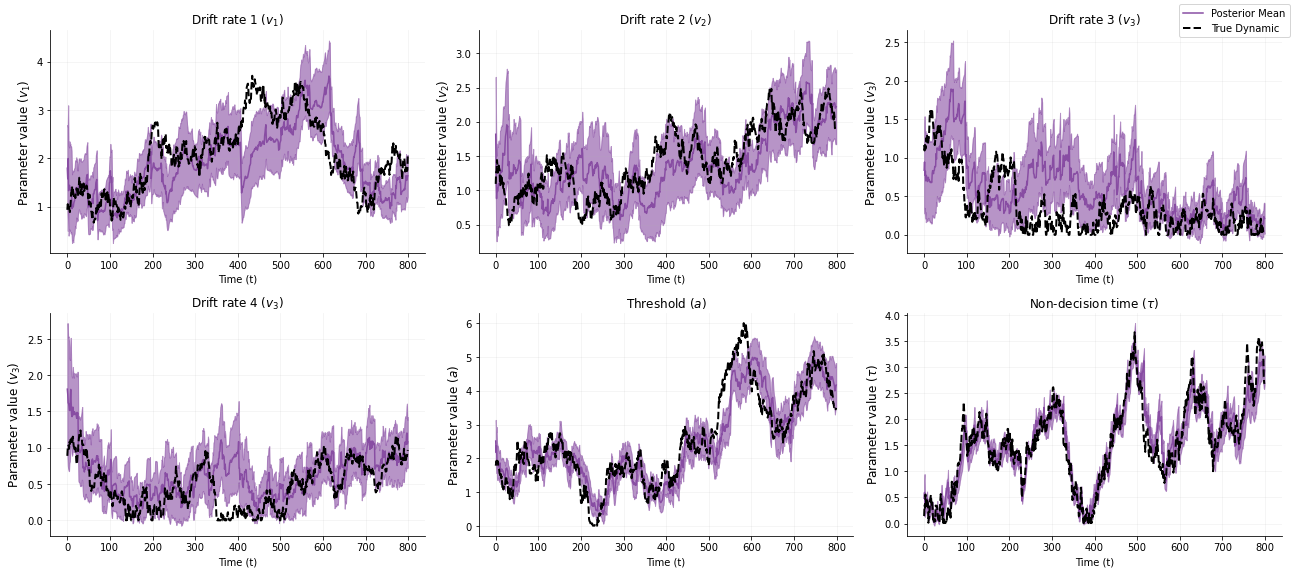

In [129]:
which = 4
post_d, post_s = network(x_nn[which:(which+1)])
ground_truths = theta_d[which]
par_labels = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
par_names = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_3$', r'$a$', r'$\tau$']
plot_dynamic_posteriors(post_d, par_labels,  par_names, ground_truths)